# ALOS/ALOS-2 PALSAR/PALSAR-2 Annual Mosaics <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[alos_palsar_mosaic](https://explorer.digitalearth.africa/products/alos_palsar_mosaic),
[jers_sar_mosaic](https://explorer.digitalearth.africa/products/jers_sar_mosaic)

## Background

The ALOS/ALOS2 PALSAR is a global 25 m resolution dataset that combines data from many images captured by JAXA’s PALSAR and PALSAR-2 sensors on ALOS-1 and ALOS-2 satellites respectively. This product contains radar measurement in L-band and in HH and HV polarizations. It has a spatial resolution of 25m and is available annually for 2007 to 2010 (ALOS/PALSAR) and 2015 to 2018 (ALOS-2/PALSAR-2).
ALOS/ALOS2 PALSAR mosaic data is part of a global [dataset](https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/fnf_index.htm) provided by the Japan Aerospace Exploration Agency (JAXA) Earth Observation Research Center. Historically, the JERS annual mosaic is generated from images acquired by the SAR sensor on the Japanese Earth Resources Satellite-1 (JERS-1) satellite. 

DE Africa's ALOS/ALOS-2 PALSAR/PALSAR-2 and JERS annual mosaic are Normalized Radar Backscatter data, for which Radiometric Terrain Correction (RTC) has been applied to data acquired with different imaging geometries over the same region. The relevant coverage and metadata of the ALOS/ALOS2 PALSAR dataset can be viewed on [DE Africa Metadata Explorer](https://explorer.dev.digitalearth.africa/products/alos_palsar_mosaic/extents) while the JERS dataset coverage can be access via this [link](https://explorer.dev.digitalearth.africa/products/jers_sar_mosaic) that forms a single, cohesive Analysis Ready Data (ARD) package, which allows you to analyse radar backscatter data as is without the need to apply additional corrections.

**Important details:**

* ALOS/ALOS2 PALSAR annual mosaic product specifications

    * Number of bands: `5`
    * To achieve backscatter in decibel unit, convert backscatter values in Digital Number (DN) using $ 10 * log10(DN^2) - 83.0 $
    * Mask specification includes `0` for `no-data`, `50` for water, `100` for lay_over, `150` for shadowing and `255` for land
    * Observation date is expressed as days after launch, which are Jan. 24, 2006 and May. 24, 2014 for PALSAR and PALSAR-2 respectively
    * Native pixel alignment is `centre`
    * Date-range: selected years from 2007 to 2018
    * Spatial resolution: 25 x 25 m
    
* JERS annual mosaic product specifications

    * Number of bands: `4`
    * To achieve backscatter in decibel unit, convert backscatter values in Digital Number (DN) using $ 10 * log10(DN^2) - 84.66 $
    * Mask specification includes `0` for `no-data`, `50` for water, `100` for lay_over, `150` for shadowing and `255` for land
    * Observation date is expressed as days after launch, which is Feb. 11, 1992 for JERS-1
    * Native pixel alignment is `centre`
    * Date-range: 1996
    * Spatial resolution: 25 x 25 m

For a detailed description of DE Africa's ALOS/ALOS2 PALSAR archive, see the DE Africa's [ALOS/ALOS2 technical specifications documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/ALOS_PALSAR_annual_mosaic_specs.html).

## Description

In this notebook we will load **ALOS PALSAR** data using [dc.load()](../Beginners_guide/03_Loading_data.ipynb) to return a time series of satellite images from a single sensor.

Topics covered include:
1. Inspecting the ALOS PALSAR products and measurements available in the datacube
2. Using the native `dc.load()` function to load in dual polarization ALOS PALSAR data and visualise
3. Using `dc.load()` function to load single polarization JERS mosaic and visualise

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline
import datacube
import sys
import math 
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from xarray.ufuncs import isfinite

from deafrica_tools.plotting import rgb 
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="ALOS")

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's SAR products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
dc.list_products().loc[dc.list_products()['description'].str.contains('SAR')]

,name,description,license,default_crs,default_resolution
name,,,,,
alos_palsar_mosaic,alos_palsar_mosaic,ALOS/PALSAR and ALOS-2/PALSAR-2 annual mosaic ...,None,EPSG:4326,"(-0.000222222222222, 0.000222222222222)"
jers_sar_mosaic,jers_sar_mosaic,JERS-1 SAR annual mosaic tiles generated for u...,None,EPSG:4326,"(-0.000222222222222, 0.000222222222222)"


### List measurements

We can further inspect the data available for each SAR product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [4]:
productA = "alos_palsar_mosaic"

In [5]:
measurements = dc.list_measurements()
measurements.loc[productA]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
hh,hh,uint16,1,0.0,[hh],NaN
hv,hv,uint16,1,0.0,[hv],NaN
date,date,uint16,1,0.0,[date],NaN
linci,linci,uint8,1,0.0,"[local incidence angle, linci, incidence]",NaN
mask,mask,uint8,1,0.0,[mask],"{'category': {'bits': [0, 1, 2, 3, 4, 5, 6, 7]..."


## Load ALOS PALSAR dataset using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

In the example below, we will load ALOS PALSAR for Cairo and its surrounding in Egypt between 2007 and 2018. 

We will load data from two polarizations, as well as the data mask (`'mask'`) and observation date. The data is loaded in native EPSG:4326 coordinate reference system (CRS). It can be reprojected if `output_crs` and `resolution` are defined in the query.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.



In [6]:
# Setting the query for area in the proximity of Cairo 
lon = (31.90, 32.10)
lat = (30.37, 30.55)
query = {"x": lon,
         "y": lat,
         "time": ("2007", "2018")}

### Visualise the selected area 

In [7]:
display_map(x=lon, y=lat)

In [8]:
#loading the data with the mask band included 
bands = ['hh','hv','mask', 'date']
ds_ALOS = dc.load(product='alos_palsar_mosaic',
             measurements=bands,
             **query)

print(ds_ALOS)

<xarray.Dataset>
Dimensions:      (time: 8, latitude: 811, longitude: 900)
Coordinates:
  * time         (time) datetime64[ns] 2007-07-02T11:59:59.500000 ... 2018-07...
  * latitude     (latitude) float64 30.55 30.55 30.55 ... 30.37 30.37 30.37
  * longitude    (longitude) float64 31.9 31.9 31.9 31.9 ... 32.1 32.1 32.1 32.1
    spatial_ref  int32 4326
Data variables:
    hh           (time, latitude, longitude) uint16 3130 1436 1652 ... 749 789
    hv           (time, latitude, longitude) uint16 1564 687 630 ... 376 365 311
    mask         (time, latitude, longitude) uint8 255 255 255 ... 255 255 255
    date         (time, latitude, longitude) uint16 582 582 582 ... 1137 1137
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


In [9]:
#creation of a new band (HV/HH = hvhh) for RGB display 
ds_ALOS['hvhh'] = ds_ALOS.hv / ds_ALOS.hh

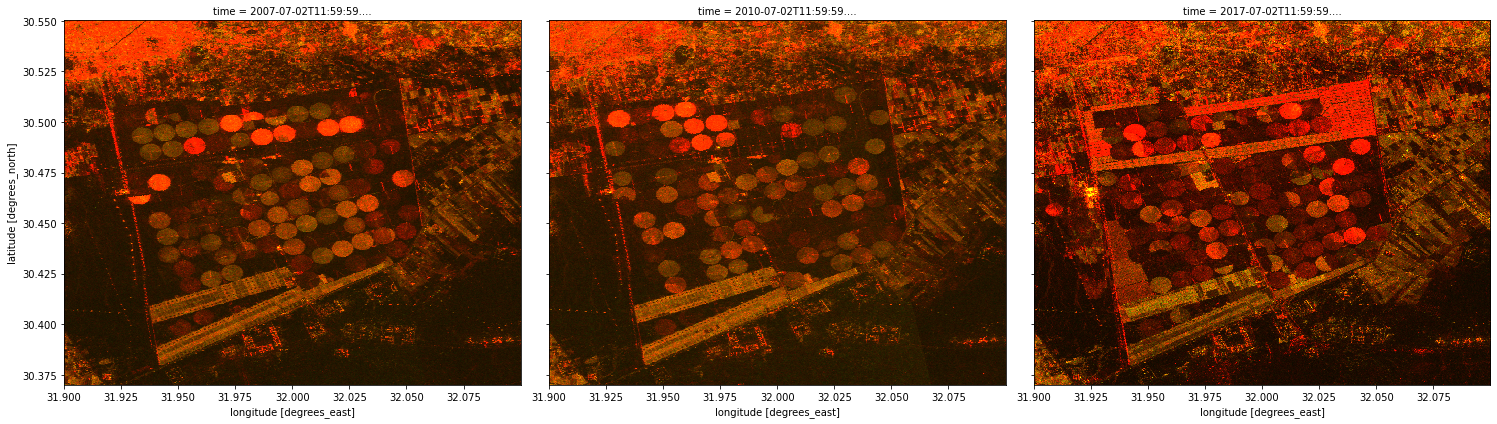

In [10]:
# Set the timesteps to visualise
timesteps = [0,3,6]

# Generate RGB plots at each timestep
rgb(ds_ALOS, bands=['hh','hv','hvhh'], index=timesteps)

### Inspection of observation date

Each annual mosaic is created from multiple oberservations from a year. This may result in discontinuity across images as seen above. It also means mosaics from different years may come from different seasons. 

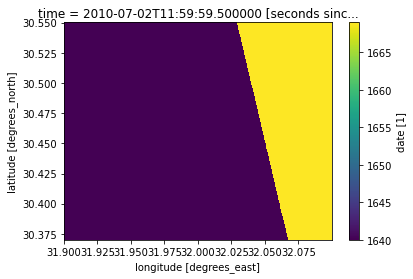

In [11]:
# plot date for a mosaic
ds_ALOS.isel(time=3).date.plot.imshow(robust=True);

The observation date should be considered when evaluating change detected from year to year. In this example, we find the earliest, latest and median observation dates for each mosaic loaded.

In [12]:
min_days = ds_ALOS.date.min(dim=['latitude','longitude']).values
max_days = ds_ALOS.date.max(dim=['latitude','longitude']).values
med_days = ds_ALOS.date.median(dim=['latitude','longitude']).astype(min_days.dtype).values

In [13]:
# Define ALOS and ALOS-2 launch dates

alos_launch = np.datetime64('2006-01-24')
alos2_launch = np.datetime64('2014-05-24')

In [14]:
# Calculate earliest, latest and median observation dates, using launch dates and offsets reported in the date band

indexed_time = ds_ALOS.time.values
min_dates = np.empty(len(indexed_time),dtype='<M8[D]')
max_dates = np.empty(len(indexed_time),dtype='<M8[D]')
med_dates = np.empty(len(indexed_time),dtype='<M8[D]')

for i, time in enumerate(indexed_time):
    if time < np.datetime64('2015'): 
        min_dates[i] = alos_launch + np.timedelta64(min_days[i], 'D')
        max_dates[i] = alos_launch + np.timedelta64(max_days[i], 'D')
        med_dates[i] = alos_launch + np.timedelta64(med_days[i], 'D')
    else:
        min_dates[i] = alos2_launch + np.timedelta64(min_days[i], 'D')
        max_dates[i] = alos2_launch + np.timedelta64(max_days[i], 'D')
        med_dates[i] = alos2_launch + np.timedelta64(med_days[i], 'D')

The date ranges below show that the observations can span a few months. Occasionally, data used may be from another year.

In [15]:
for i in zip(min_dates, max_dates, (max_dates - min_dates).astype(int)): print("Date range and span (in days)", i)

Date range and span (in days) (numpy.datetime64('2007-06-27'), numpy.datetime64('2007-08-29'), 63)
Date range and span (in days) (numpy.datetime64('2008-07-16'), numpy.datetime64('2008-09-29'), 75)
Date range and span (in days) (numpy.datetime64('2009-08-17'), numpy.datetime64('2009-09-03'), 17)
Date range and span (in days) (numpy.datetime64('2010-07-22'), numpy.datetime64('2010-08-20'), 29)
Date range and span (in days) (numpy.datetime64('2015-07-07'), numpy.datetime64('2015-07-07'), 0)
Date range and span (in days) (numpy.datetime64('2016-06-07'), numpy.datetime64('2016-06-07'), 0)
Date range and span (in days) (numpy.datetime64('2017-07-04'), numpy.datetime64('2017-07-04'), 0)
Date range and span (in days) (numpy.datetime64('2017-07-04'), numpy.datetime64('2018-03-27'), 266)


In [16]:
# Assign median dates to be the timestamps
ds_ALOS['time'] =  med_dates

### Coverting DN Values to Decibel Units 

Since backscatter data is provided as digital number (DN), it can be converted to backscatter in decibel (dB) unit to enhance contrast using the provided conversion equation. Before converting to decibel, we also apply the data mask to exclude pixels in radar shadow or with layerover.

In [17]:
#convert DN to dB values
ds_ALOS['hh_db'] =  10 * np.log10(ds_ALOS.hh.where(ds_ALOS.mask.isin([50,255]))**2) - 83.0
ds_ALOS['hv_db'] =  10 * np.log10(ds_ALOS.hv.where(ds_ALOS.mask.isin([50,255]))**2) - 83.0
ds_ALOS['hvhh_db'] = ds_ALOS['hv_db'] - ds_ALOS ['hh_db']

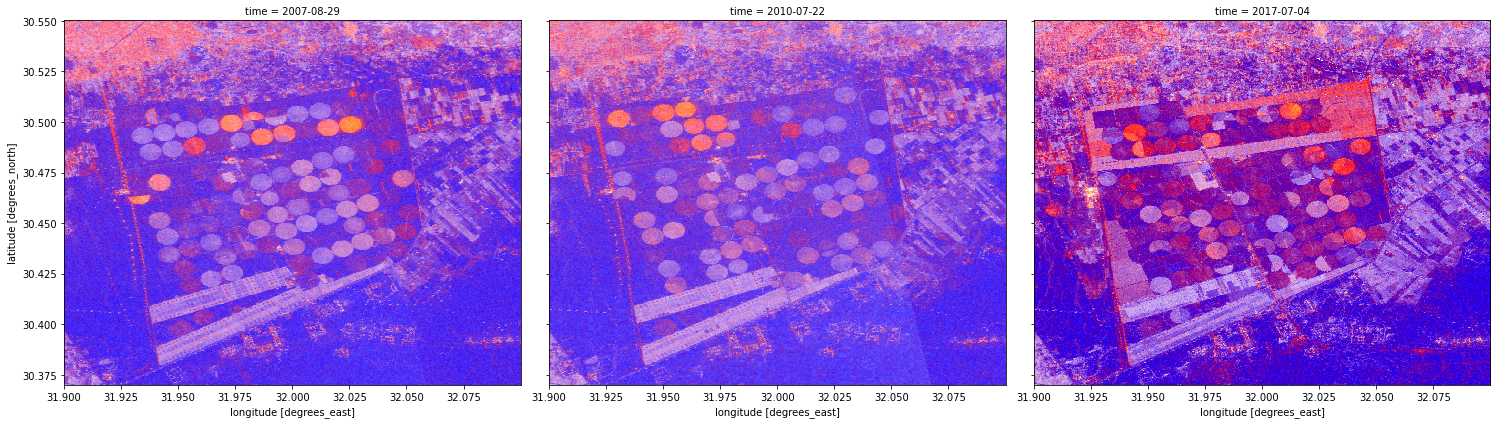

In [18]:
# Set the timesteps to visualise
timesteps = [0,3,6]

# Generate RGB plots at each timestep
rgb(ds_ALOS, bands=['hh_db','hv_db','hvhh_db'], index=timesteps)

## Histogram Analysis for ALOS/ALOS-2 PALSAR Dataset 

Use histograms to inspect the distribution of backscatter values.

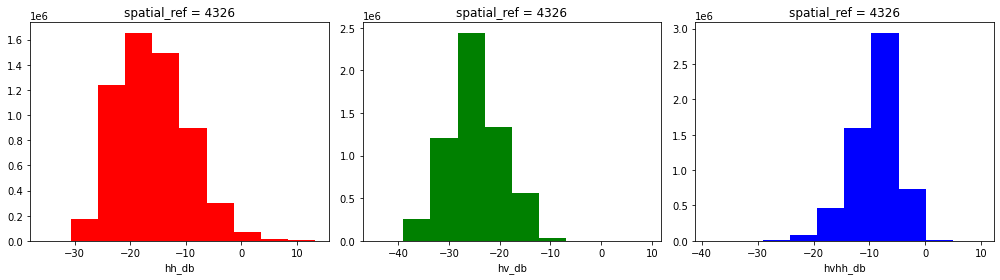

In [19]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ds_ALOS.hh_db.plot.hist(ax=ax[0], facecolor='red')
ds_ALOS.hv_db.plot.hist(ax=ax[1], facecolor='green')
ds_ALOS.hvhh_db.plot.hist(ax=ax[2], facecolor='blue')
plt.tight_layout()

## Load JERS dataset using `dc.load()`

In the example below, we will load JERS annual mosaic for Cairo and its surrounding in Egypt in 1996. 

We will load data from HH polarization, as well as the data mask (`mask`). The data is loaded in native EPSG:4326 coordinate reference system (CRS). It can be reprojected if `output_crs` and `resolution` are defined in the query.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [20]:
# Setting the query for area in the proximity of Cairo 
lon = (31.90, 32.10)
lat = (30.37, 30.55)
query_jers = {"x": lon,
         "y": lat,
         "time": ("1996")}

In [21]:
#loading the data with the mask band included 
bands = ['hh','mask']
ds_JERS = dc.load(product='jers_sar_mosaic',
             measurements=bands,
             **query_jers)

print(ds_JERS)

<xarray.Dataset>
Dimensions:      (time: 1, latitude: 811, longitude: 900)
Coordinates:
  * time         (time) datetime64[ns] 1996-07-01T23:59:59.500000
  * latitude     (latitude) float64 30.55 30.55 30.55 ... 30.37 30.37 30.37
  * longitude    (longitude) float64 31.9 31.9 31.9 31.9 ... 32.1 32.1 32.1 32.1
    spatial_ref  int32 4326
Data variables:
    hh           (time, latitude, longitude) uint16 6505 6953 4974 ... 2750 2750
    mask         (time, latitude, longitude) uint8 255 255 255 ... 255 255 255
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


In [22]:
#convert DN values in JERS dataset to dB values
ds_JERS['hh_db'] =  10 * np.log10(ds_JERS.hh.where(ds_JERS.mask.isin([50,255]))**2) - 84.66

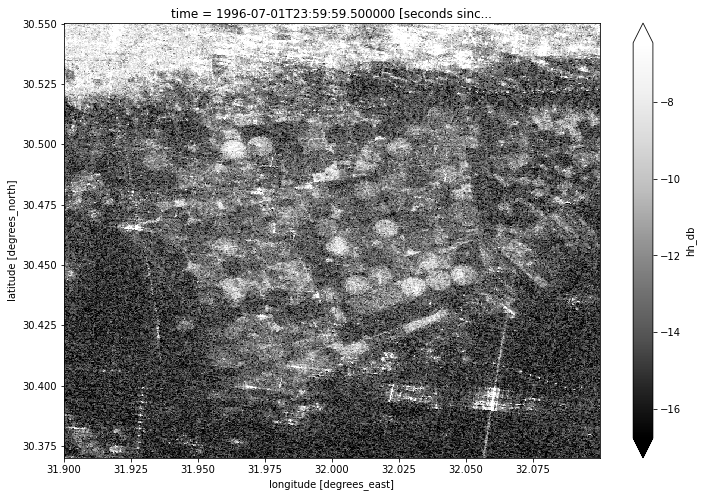

In [23]:
# Plot all VH observations for the year
ds_JERS.hh_db.plot(cmap="Greys_r", robust=True,size=8);

### Histogram Analysis for JERS HH Polarization 

Inspect backscatter distribution in this area

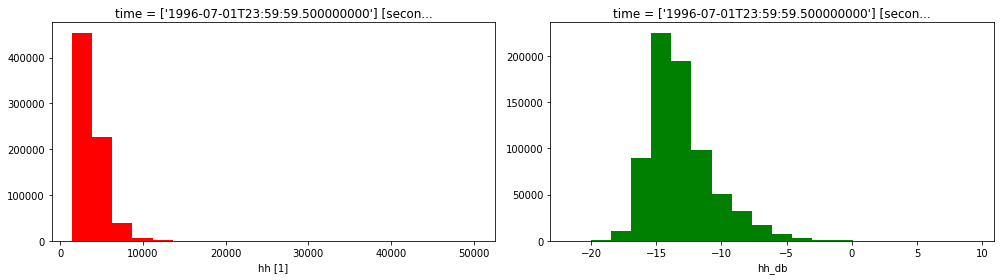

In [24]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ds_JERS.hh.plot.hist(ax=ax[0], bins=20, facecolor='red')
ds_JERS.hh_db.plot.hist(ax=ax[1], bins=20, facecolor='green')
plt.tight_layout()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [26]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-03-29'